## Installing need Packages

In [ ]:
%%capture
!pip install bertopic
!pip install -U sentence-transformers
!pip install hdbscan
!pip install bitsandbytes
!pip install accelerate

## Import Packages

In [ ]:
from bertopic import BERTopic

In [ ]:
from transformers.pipelines import pipeline
from sentence_transformers import SentenceTransformer
import pandas as pd
import transformers
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig, pipeline, TextStreamer, AutoConfig, AutoTokenizer
import pandas as pd
import nltk
import re
import string
from sentence_transformers import SentenceTransformer
from umap import UMAP
from hdbscan import HDBSCAN
from sklearn.feature_extraction.text import CountVectorizer
from bertopic.vectorizers import ClassTfidfTransformer
from bertopic import BERTopic
import pandas as pd
import numpy as np

## Preparing the data

In [ ]:
# # Mount google drive for data
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
data = pd.read_excel('/content/BANSOS.xlsx')
docs = data['Review']
# review_bpjs = data['Review_BPJS'].dropna()
# review_bmkg = data['Review_BMKG'].dropna()
# review_kci = data['Review_KCI'].dropna()
# review_satusehat = data['Review_SATUSEHAT'].dropna()
# review_bansos = data['Review_BANSOS'].dropna()

In [ ]:
# print(f'Panjang review BPJS:{len(review_bpjs)}')
# print(f'Panjang review BMKG:{len(review_bmkg)}')
# print(f'Panjang review KCI:{len(review_kci)}')
# print(f'Panjang review SATUSEHAT:{len(review_satusehat)}')
# print(f'Panjang review BANSOS:{len(review_bansos)}')

Panjang review BPJS:2151
Panjang review BMKG:2096
Panjang review KCI:424
Panjang review SATUSEHAT:2696
Panjang review BANSOS:2643


In [ ]:
# docs = pd.concat([review_bpjs, review_bmkg, review_kci, review_satusehat, review_bansos]).reset_index(drop=True)


# labels = (['BPJS'] * len(review_bpjs) +
#           ['BMKG'] * len(review_bmkg) +
#           ['KCI'] * len(review_kci) +
#           ['SATUSEHAT'] * len(review_satusehat) +
#           ['BANSOS'] * len(review_bansos))

In [ ]:
docs

0       aplikasi bikin emosi . pemerintah tidak niat k...
1                                        deng dan ridonya
2       ini aplikasi cuman mau curi data kalian saja ,...
3                        informasi dong kalau ada bantuan
4       pantes rating rendah . sudah daftar pas mau ma...
                              ...                        
5207                                       buruk sekali .
5208    susah mengisi datanya , eh pas mau verivikasi ...
5209    ini sebenarnya siapa yang harus cek sih . suda...
5210    aplikasi apak dan ini . udad daftar berkali2 ....
5211                           cek nama2 penerima kpm pkh
Name: Review, Length: 5212, dtype: object

In [ ]:
# Get the dataset information
print(docs.info())

<class 'pandas.core.series.Series'>
RangeIndex: 5212 entries, 0 to 5211
Series name: Review
Non-Null Count  Dtype 
--------------  ----- 
5212 non-null   object
dtypes: object(1)
memory usage: 40.8+ KB
None


In [ ]:
print(docs.describe())

count                                                  5212
unique                                                 5212
top       aplikasi bikin emosi . pemerintah tidak niat k...
freq                                                      1
Name: Review, dtype: object


In [ ]:
docs_lengths = docs.apply(len)
print(docs_lengths.describe())

count    5212.000000
mean      107.691097
std        93.597421
min         1.000000
25%        43.000000
50%        81.000000
75%       141.000000
max       579.000000
Name: Review, dtype: float64


In [ ]:
# checking missing values
missing_values = docs.isnull().sum()
print(f"Missing values in 'Review': {missing_values}")

Missing values in 'Review': 0


In [ ]:
# checking duplicate values
duplicate_values = docs.duplicated().sum()
print(f"Duplicate values in 'Review': {duplicate_values}")

Duplicate values in 'Review': 0


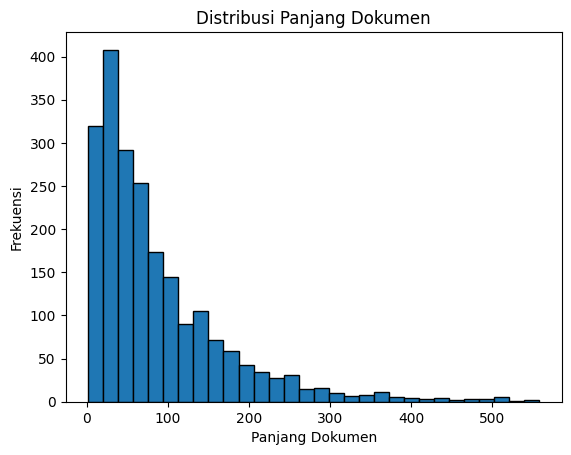

In [ ]:
import matplotlib.pyplot as plt

plt.hist(docs_lengths, bins=30, edgecolor='k')
plt.xlabel('Panjang Dokumen')
plt.ylabel('Frekuensi')
plt.title('Distribusi Panjang Dokumen')
plt.show()

## Sub-Model

In [ ]:
# # Memastikan panjang docs dan labels sama
# assert len(docs) == len(labels), "Panjang docs dan labels tidak sama!"

In [ ]:
from sentence_transformers import SentenceTransformer

# Pre-calculate embeddings
embedding_model = SentenceTransformer('firqaaa/indo-sentence-bert-base')
embeddings = embedding_model.encode(docs, show_progress_bar=True)

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/118 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/4.88k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.10k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/498M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/551 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/229k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/709k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/163 [00:00<?, ?it/s]

In [ ]:
embeddings

array([[ 0.532076  ,  0.5007638 ,  0.8884784 , ...,  1.6813252 ,
        -0.35350525, -0.8624146 ],
       [-1.1036526 ,  1.0649893 ,  0.22895968, ...,  0.20775063,
         0.41336873,  0.0658328 ],
       [-0.90339077,  0.27631322, -0.35921624, ..., -0.00701342,
        -0.24095051,  0.84837407],
       ...,
       [-0.5150425 ,  0.6843465 ,  1.1709437 , ..., -0.5136265 ,
         0.36038724, -0.02452246],
       [-0.1453411 ,  1.6407017 ,  1.386847  , ...,  0.95873797,
        -0.23904786,  0.22857408],
       [-1.204221  ,  0.7055025 ,  1.1990956 , ..., -0.67615485,
        -0.14952601,  0.0196506 ]], dtype=float32)

In [ ]:
reduced_embeddings = UMAP(n_neighbors = 15, n_components = 1, min_dist = 0.0, metric= 'cosine', random_state = 42).fit_transform(embeddings)

In [ ]:
reduced_embeddings

array([[ 7.434359 ],
       [-3.9407427],
       [13.559125 ],
       ...,
       [ 4.9227433],
       [11.253858 ],
       [ 2.9696884]], dtype=float32)

## Representation Model

In [ ]:
cache_dir = "/content/cache_dir"  # Atur direktori cache jika diperlukan
model_id = "guardrail/llama-2-7b-guanaco-instruct-sharded"
# model_id = "tribber93/Mistral-7B-Instruct-v0.1-sharded-bf16-5GB"

bnb_config = transformers.BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

config = AutoConfig.from_pretrained(model_id, trust_remote_code=True)
config.init_device = 'cuda:0'  # Unclear whether this really helps a lot or interacts with device_map.

tokenizer = AutoTokenizer.from_pretrained(model_id, cache_dir=cache_dir)
tokenizer.pad_token = tokenizer.eos_token
model = AutoModelForCausalLM.from_pretrained(
    model_id,
    config=config,
    quantization_config=bnb_config,
    device_map='auto',
    trust_remote_code=True,
    cache_dir=cache_dir
)


config.json:   0%|          | 0.00/633 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/676 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/434 [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.llama.tokenization_llama_fast.LlamaTokenizerFast'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


model.safetensors.index.json:   0%|          | 0.00/26.8k [00:00<?, ?B/s]

model-00001-of-00014.safetensors:   0%|          | 0.00/1.96G [00:00<?, ?B/s]

model-00002-of-00014.safetensors:   0%|          | 0.00/1.93G [00:00<?, ?B/s]

model-00003-of-00014.safetensors:   0%|          | 0.00/1.93G [00:00<?, ?B/s]

model-00004-of-00014.safetensors:   0%|          | 0.00/1.98G [00:00<?, ?B/s]

model-00005-of-00014.safetensors:   0%|          | 0.00/1.89G [00:00<?, ?B/s]

model-00006-of-00014.safetensors:   0%|          | 0.00/1.98G [00:00<?, ?B/s]

model-00007-of-00014.safetensors:   0%|          | 0.00/1.93G [00:00<?, ?B/s]

model-00008-of-00014.safetensors:   0%|          | 0.00/1.93G [00:00<?, ?B/s]

model-00009-of-00014.safetensors:   0%|          | 0.00/1.98G [00:00<?, ?B/s]

model-00010-of-00014.safetensors:   0%|          | 0.00/1.89G [00:00<?, ?B/s]

model-00011-of-00014.safetensors:   0%|          | 0.00/1.98G [00:00<?, ?B/s]

model-00012-of-00014.safetensors:   0%|          | 0.00/1.93G [00:00<?, ?B/s]

model-00013-of-00014.safetensors:   0%|          | 0.00/1.93G [00:00<?, ?B/s]

model-00014-of-00014.safetensors:   0%|          | 0.00/1.69G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/14 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/137 [00:00<?, ?B/s]

In [ ]:
generator = transformers.pipeline(
    model=model, tokenizer=tokenizer,
    task='text-generation',
    temperature=0.1,
    max_new_tokens=500,
    repetition_penalty=1.1
)

In [ ]:
# System prompt describes information given to all conversations
system_prompt = """
<s>[INST] <<SYS>>
You are a helpful, respectful and honest assistant for labeling topics.
<</SYS>>
"""

In [ ]:
# Example prompt demonstrating the output we are looking for
example_prompt = """
I have a topic that contains the following documents:
- Traditional diets in most cultures were primarily plant-based with a little meat on top, but with the rise of industrial style meat production and factory farming, meat has become a staple food.
- Meat, but especially beef, is the word food in terms of emissions.
- Eating meat doesn't make you a bad person, not eating meat doesn't make you a good one.

The topic is described by the following keywords: 'meat, beef, eat, eating, emissions, steak, food, health, processed, chicken'.

Based on the information about the topic above, please create a short label of this topic. Make sure you to only return the label and nothing more.

[/INST] Environmental impacts of eating meat
"""

In [ ]:
# Our main prompt with documents ([DOCUMENTS]) and keywords ([KEYWORDS]) tags
main_prompt = """
[INST]
I have a topic that contains the following documents:
[DOCUMENTS]

The topic is described by the following keywords: '[KEYWORDS]'.

Based on the information about the topic above, please create a short label of this topic. Make sure you to only return the label and nothing more and use indonesian.
[/INST]
"""

In [ ]:
prompt = system_prompt + example_prompt + main_prompt

In [ ]:
from bertopic.representation import KeyBERTInspired, MaximalMarginalRelevance, TextGeneration

# KeyBERT
keybert = KeyBERTInspired()

# MMR
mmr = MaximalMarginalRelevance(diversity=0.3)

# Text generation with Llama 2
llama2 = TextGeneration(generator, prompt=prompt)

# All representation models
representation_model = {
    "KeyBERT": keybert,
    "Llama2": llama2,
    "MMR": mmr,
}

# representation_model = {
#     "Llama2": llama2,
# }

In [ ]:
from nltk.corpus import stopwords

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
list_stopwords = stopwords.words('indonesian')

In [ ]:
vectorizer_model  = CountVectorizer(stop_words = list_stopwords)

## BERTopic

In [ ]:
from umap import UMAP
from hdbscan import HDBSCAN

umap_model = UMAP(n_neighbors=15,
                  n_components=5,
                  min_dist=0.0,
                  metric='cosine',
                  random_state=100)

hdb_scan = HDBSCAN(
    min_cluster_size = 25,
    metric = 'euclidean',
    cluster_selection_method = 'eom',
    prediction_data = True
)

In [ ]:
from bertopic import BERTopic

topic_model = BERTopic(

  # Sub-models
  embedding_model=embedding_model,
  umap_model=umap_model,
  hdbscan_model=hdb_scan,
  representation_model=representation_model,
  vectorizer_model=vectorizer_model,

  # Hyperparameters
  # top_n_words=10,
  verbose=True
)


Fit model

In [ ]:
# Train model
topics, probs = topic_model.fit_transform(docs, embeddings)

2024-06-28 02:32:48,934 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-06-28 02:33:00,742 - BERTopic - Dimensionality - Completed ✓
2024-06-28 02:33:00,745 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-06-28 02:33:00,953 - BERTopic - Cluster - Completed ✓
2024-06-28 02:33:00,962 - BERTopic - Representation - Extracting topics from clusters using representation models.
100%|██████████| 30/30 [02:14<00:00,  4.47s/it]
2024-06-28 02:35:17,255 - BERTopic - Representation - Completed ✓


In [ ]:
topic_info = topic_model.get_topic_info()
topic_info

,Topic,Count,Name,Representation,KeyBERT,Llama2,MMR,Representative_Docs
0,-1,2038,-1_aplikasi_nya_data_daftar,"[aplikasi, nya, data, daftar, login, bansos, a...","[email, login, password, error, verifikasi, pa...",[Label: Masalah dalam mengakses aplikasi cek b...,"[aplikasi, nya, data, daftar, login, bansos, a...",[sudah daftar dari lama tapi tidak bisa login ...
1,0,453,0_aplikasi_login_daftar_unduh,"[aplikasi, login, daftar, unduh, berguna, biki...","[aplikasi, aplikasinya, playstore, instalan, s...","[Label: Aplikasi Tidak Berguna?, , , , , , , ,...","[aplikasi, login, daftar, unduh, berguna, biki...","[aplikasi tidak jelas padahal, aplikasi apa in..."
2,1,440,1_oke_susah_bagus_coba,"[oke, susah, bagus, coba, masuk, puas, wk, man...","[oke, bagus, mantap, sip, lumayan, ya, aamiin,...","[Oke Topic Label:\n""Oke Topic""\n\n(Note: I apo...","[oke, susah, bagus, coba, masuk, puas, wk, man...","[oke banget, oke . bagus, oke bagus .]"
3,2,209,2_usulan_respons_dinsos_cek,"[usulan, respons, dinsos, cek, pengajuan, tang...","[usulan, usulannya, pengajuan, error, ditolak,...","[Label: ""Kendala dalam mengirim usulan dan men...","[usulan, respons, dinsos, cek, pengajuan, tang...","[aplikasi tidak berguna , usulan tidak ada res..."
4,3,185,3_pemerintah_aplikasi_masyarakat_uang,"[pemerintah, aplikasi, masyarakat, uang, rakya...","[pemerintah, kementrian, korupsi, korup, aplik...",[Label: Masalah Aplikasi Pemerintah untuk Masy...,"[pemerintah, aplikasi, masyarakat, uang, rakya...","[aplikasi pemerintah tidak benar nih, ini lah ..."
5,4,144,4_aktivasi_tunggu_verifikasi_minggu,"[aktivasi, tunggu, verifikasi, minggu, email, ...","[verifikasinya, emailnya, email, aktivasinya, ...","[Label: ""Kendala Aktivasi Akun"", , , , , , , ,...","[aktivasi, tunggu, verifikasi, minggu, email, ...",[sudah daftar tapi aku tidak di verifikasi sud...
6,5,138,5_keluarga_rumah_bantuan_desa,"[keluarga, rumah, bantuan, desa, orang, anak, ...","[kemensos, dinsos, miskin, bantuan, bansos, ke...","[""Bantuan Keluarga Miskin""\n\nThis label captu...","[keluarga, rumah, bantuan, desa, orang, anak, ...","[saya dari keluarga miskin , tapi tidak pernah..."
7,6,137,6_email_aktivasi_masuk_login,"[email, aktivasi, masuk, login, daftar, balasa...","[emailnya, email, gmail, login, password, veri...","[Label: Masalah Email dan Aktivasi, , , , , , ...","[email, aktivasi, masuk, login, daftar, balasa...",[sudah dapat email aktivasi tapi tidak bisa lo...
8,7,125,7_login_daftar_akun_pas,"[login, daftar, akun, pas, terdaftar, berhasil...","[login, loginnya, loginya, pendaftaran, akun, ...","[Login and Daftar Issues, , , , , , , , , ]","[login, daftar, akun, pas, terdaftar, berhasil...","[sudah daftar tapi belum bisa login ., sudah d..."
9,8,122,8_error_perbaikan_tolong_nya,"[error, perbaikan, tolong, nya, aplikasi, perb...","[error, erorr, aplikasi, pembaruan, perbaikan,...","[Label: Errors in Applications, , , , , , , , , ]","[error, perbaikan, tolong, nya, aplikasi, perb...","[aplikasi masa kini banyak error nya, aplikasi..."


Highest 10 Topic

In [ ]:
print(topic_info.dtypes)
llama2_info = topic_info['Representative_Docs']
# llama2_info

Topic                   int64
Count                   int64
Name                   object
Representation         object
KeyBERT                object
Llama2                 object
MMR                    object
Representative_Docs    object
dtype: object


In [ ]:
topic_freq = topic_model.get_topic_info()
# print(topic_freq.head(10))

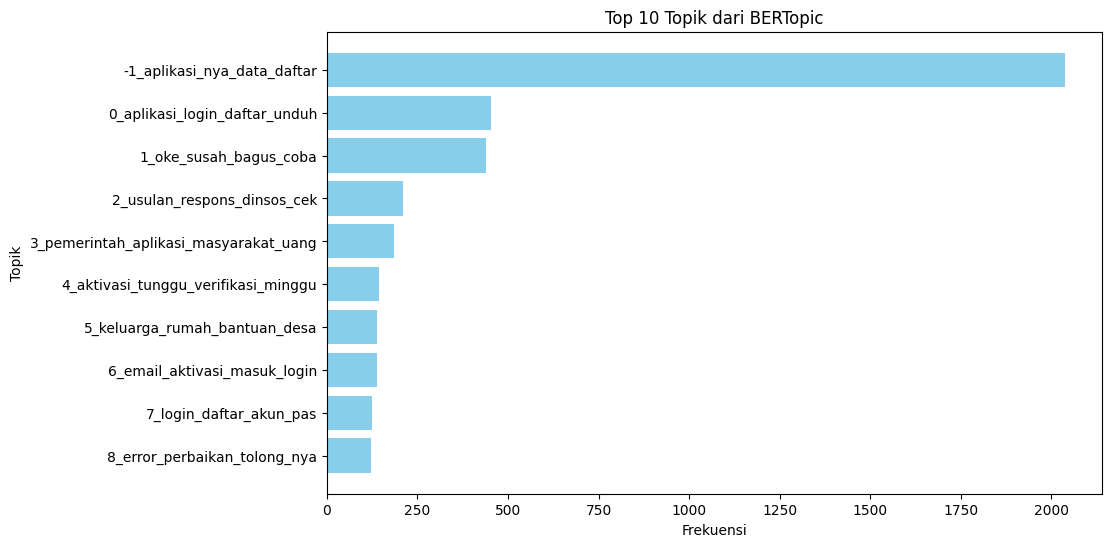

In [ ]:
import matplotlib.pyplot as plt
top_n = 10
top_topics = topic_freq.head(top_n)

plt.figure(figsize=(10, 6))
plt.barh(top_topics['Name'], top_topics['Count'], color='skyblue')
plt.xlabel('Frekuensi')
plt.ylabel('Topik')
plt.title(f'Top {top_n} Topik dari BERTopic')
plt.gca().invert_yaxis()
plt.show()

In [ ]:
topic_model.get_topic(0)

[('aplikasi', 0.08093942941811666),
 ('login', 0.03297919026303502),
 ('daftar', 0.032978783729959195),
 ('unduh', 0.032801842514991915),
 ('berguna', 0.03190825510862447),
 ('bikin', 0.02851502707543997),
 ('abal', 0.024597194663048425),
 ('nya', 0.023354662423572484),
 ('masuk', 0.021645951225104345),
 ('buka', 0.020556273492409818)]

In [ ]:
topic_model.get_representative_docs()

{-1: ['sudah daftar dari lama tapi tidak bisa login ke akun cek bansos , selalu keluar tulisan data belum di aktivasi',
  'kenapa ya pas saya mau buat akun baru selalu tulisan nya seperti ini alamat tidak sesuai dengan ktp padahal saya isi di form nya sudah sama dengan ktp . terus selain itu ada error 205 apa maksudnya ya . tolong lah bantuan nya supaya di perbaiki , kok tidak bisa terus ya padahal sudah sering coba buat akun , masih saja selalu begitu . mohon bantuan nya lah .',
  'tolong di perbaikan aplikasi cek bansos nya .'],
 0: ['aplikasi tidak jelas padahal',
  'aplikasi apa ini ,',
  'tidak bisa aplikasi dan tidak guna aplikasi'],
 1: ['oke banget', 'oke . bagus', 'oke bagus .'],
 2: ['aplikasi tidak berguna , usulan tidak ada respons',
  'kenapa selalu error aplikasi saat tambah usulan',
  'sudah bisa login tapi terjadi error saat melakukan usulan'],
 3: ['aplikasi pemerintah tidak benar nih',
  'ini lah aplikasi kayak orang punya error terus taik , pemerintah kah yang buat i

In [ ]:
dt = pd.DataFrame({"topics":topics,"document":docs})
# dt.pd
dt

,topics,document
0,3,aplikasi bikin emosi . pemerintah tidak niat k...
1,1,deng dan ridonya
2,16,"ini aplikasi cuman mau curi data kalian saja ,..."
3,10,informasi dong kalau ada bantuan
4,-1,pantes rating rendah . sudah daftar pas mau ma...
...,...,...
5207,1,buruk sekali .
5208,17,"susah mengisi datanya , eh pas mau verivikasi ..."
5209,-1,ini sebenarnya siapa yang harus cek sih . suda...
5210,0,aplikasi apak dan ini . udad daftar berkali2 ....


In [ ]:
topic_model.visualize_topics()

In [ ]:
topic_model.visualize_barchart()

In [ ]:
llama2_labels = [label[0][0].split("\n")[0] for label in topic_model.get_topics(full=True)["Llama2"].values()]
topic_model.set_topic_labels(llama2_labels)

In [ ]:
# Mendapatkan dokumen dengan probabilitas topik tertinggi
topik_id = 0
top_docs = [(doc, prob[topik_id]) for doc, prob in zip(documents, probs) if prob[topik_id] > 0.1]

# Menampilkan beberapa dokumen dengan probabilitas topik tertinggi
top_docs = sorted(top_docs, key=lambda x: x[1], reverse=True)[:5]
print(f"Dokumen dengan probabilitas tertinggi untuk topik {topik_id}:")
for idx, (doc, prob) in enumerate(top_docs):
    print(f"Document {idx} (Probabilitas: {prob:.2f}): {doc}")


NameError: name 'documents' is not defined

In [ ]:
hello = pd.DataFrame({"Review": docs, "Topic": topics, "Label": labels})

In [ ]:
hello.to_csv('/content/ALL Review TopMod/all_review.csv',index = False)

In [ ]:
bmkg=hello[(hello["Label"] == 'BMKG')]

topic_labels = topic_info.set_index("Topic")["Name"].to_dict()
bmkg

In [ ]:
topic_info = pd.DataFrame(topic_info)

# Pilih baris dari DataFrame hello di mana kolom "Label" memiliki nilai 'BMKG'
bmkg = hello[hello["Label"] == 'BANSOS']

# Buat kamus topic_labels dari topic_info
topic_labels = topic_info.set_index("Topic")["Name"].to_dict()

# Tambahkan kolom "Topic_Label" ke DataFrame bmkg
bmkg["Topic_Label"] = bmkg["Topic"].map(topic_labels)

bmkg.to_csv(f'/content/{variabl} TopMod/topic_doc_BANSOS.csv', index=False)

print(f"Data telah disimpan dalam bentuk CSV di /content/drive/MyDrive/{variabl}_TopMod/topic_docs.csv.")

Data telah disimpan dalam bentuk CSV di /content/drive/MyDrive/ALL Review_TopMod/topic_docs.csv.


In [ ]:
bmkg=hello[(hello["Label"] == 'BPJS') & (hello["Topic"] == -1)]
len(bmkg)

578

In [ ]:
var = hello[hello["Label"] == 'SATUSEHAT']

# Hitung jumlah dokumen untuk setiap topik dengan label 'BPJS'
topic_counts = var["Topic"].value_counts().reset_index()

# Ubah nama kolom untuk kejelasan
topic_counts.columns = ["Topic", "Count"]

# Gabungkan dengan topic_info untuk mendapatkan nama topik
topic_counts = topic_counts.merge(topic_info, on="Topic", how="left")

# Tampilkan DataFrame dengan jumlah dokumen untuk tiap-tiap topik dengan label 'BPJS'
topic_counts.to_csv('/content/ALL Review TopMod/topic_counts/SATUSEHAT_count_topic.csv',index = False)

## Saving

In [ ]:
# To save: model, reduced embeddings, representative docs
!pip install safetensors

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
variabl = 'BANSOS'

In [ ]:
import pickle

with open(f'/content/{variabl} TopMod/rep_docs_3.pickle', 'wb') as handle:
    pickle.dump(topic_model.representative_docs_, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open(f'/content/{variabl} TopMod/reduced_embeddings_3.pickle', 'wb') as handle:
    pickle.dump(reduced_embeddings, handle, protocol=pickle.HIGHEST_PROTOCOL)

# with open('filename.pickle', 'rb') as handle:
#     b = pickle.load(handle)

In [ ]:
embedding_model = "'firqaaa/indo-sentence-bert-base'"
topic_model.save(f"/content/{variabl} TopMod/topic_modelling_llama2/final_training", serialization="safetensors", save_ctfidf=True, save_embedding_model=embedding_model)

In [ ]:
import pandas as pd
from bertopic import BERTopic
import os
import shutil

df = pd.DataFrame({"topics": topics, "document": docs})

# Buat folder untuk menyimpan file CSV
output_folder = f"/content/{variabl} TopMod/csv/all"
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# Dapatkan semua topik yang ada di dataset
all_topics = df['topics'].unique()

# Pisahkan dokumen berdasarkan topik dan simpan dalam file CSV yang berbeda
for topic in all_topics:
    topic_df = df[df['topics'] == topic]
    filename = f"{output_folder}/{topic}_review.csv"
    topic_df.to_csv(filename, index=False)
    print(f"Dokumen untuk topik {topic} telah disimpan dalam {filename}.")

# Nama file zip
zip_filename = "/content/llama2_bertopic.zip"

# Buat zip file dari folder
shutil.make_archive(zip_filename.replace('.zip', ''), 'zip', output_folder)

print(f"Semua file CSV telah di-zip menjadi {zip_filename}.")

Dokumen untuk topik 3 telah disimpan dalam /content/BANSOS TopMod/csv/all/3_review.csv.
Dokumen untuk topik 1 telah disimpan dalam /content/BANSOS TopMod/csv/all/1_review.csv.
Dokumen untuk topik 16 telah disimpan dalam /content/BANSOS TopMod/csv/all/16_review.csv.
Dokumen untuk topik 10 telah disimpan dalam /content/BANSOS TopMod/csv/all/10_review.csv.
Dokumen untuk topik -1 telah disimpan dalam /content/BANSOS TopMod/csv/all/-1_review.csv.
Dokumen untuk topik 22 telah disimpan dalam /content/BANSOS TopMod/csv/all/22_review.csv.
Dokumen untuk topik 17 telah disimpan dalam /content/BANSOS TopMod/csv/all/17_review.csv.
Dokumen untuk topik 6 telah disimpan dalam /content/BANSOS TopMod/csv/all/6_review.csv.
Dokumen untuk topik 7 telah disimpan dalam /content/BANSOS TopMod/csv/all/7_review.csv.
Dokumen untuk topik 9 telah disimpan dalam /content/BANSOS TopMod/csv/all/9_review.csv.
Dokumen untuk topik 0 telah disimpan dalam /content/BANSOS TopMod/csv/all/0_review.csv.
Dokumen untuk topik 23

In [ ]:
topic_info_df = pd.DataFrame(topic_info)

# Menyimpan DataFrame ke dalam file CSV
topic_info_df.to_csv(f'/content/{variabl} TopMod/topic_info.csv', index=False)

print("Informasi topik telah disimpan ke dalam file CSV.")

Informasi topik telah disimpan ke dalam file CSV.


In [ ]:
# dt = pd.DataFrame({"topics":topics,"document":docs})
# dt.to_csv(f'/content/{variabl} TopMod/topic_docs.csv')

In [ ]:
topic_info = topic_model.get_topic_info()

# Buat DataFrame dengan topik dan dokumen
df = pd.DataFrame({"topics": topics, "document": docs})

# Buat kamus untuk mapping topik ke label dari topic_info
topic_labels = topic_info.set_index("Topic")["Name"].to_dict()

# Tambahkan kolom "label" ke DataFrame dengan menggunakan mapping
df["label"] = df["topics"].map(topic_labels)

# Simpan DataFrame ke file CSV
df.to_csv(f'/content/{variabl} TopMod/topic_docs.csv', index=False)

print(f"Data telah disimpan dalam bentuk CSV di /content/drive/MyDrive/{variabl}_TopMod/topic_docs.csv.")

Data telah disimpan dalam bentuk CSV di /content/drive/MyDrive/BANSOS_TopMod/topic_docs.csv.


In [ ]:
import os
import zipfile

def zip_folder(source_dir, output_filename):
  zip_file = zipfile.ZipFile(output_filename, 'w')
  for root, _, files in os.walk(source_dir):
    for file in files:
      full_path = os.path.join(root, file)
      zip_file.write(full_path, arcname=os.path.relpath(full_path, source_dir))
  zip_file.close()

if __name__ == '__main__':
  source_dir = f'/content/{variabl} TopMod'  # Ubah dengan nama folder yang ingin diubah
  output_filename = f'/content/{variabl} TopMod.zip'  # Ubah dengan nama file zip yang diinginkan
  zip_folder(source_dir, output_filename)

## SKIP DL

In [ ]:
gems_tm_model = BERTopic.load("/content/drive/MyDrive/gemastik/topic_modelling_llama2/final_training")

2024-06-22 16:47:30,440 - BERTopic - WARNING: You are loading a BERTopic model without explicitly defining an embedding model. If you want to also load in an embedding model, make sure to use `BERTopic.load(my_model, embedding_model=my_embedding_model)`.


In [ ]:
gems_tm_model.visualize_barchart()

In [ ]:
gems_tm_model.get_topic_info(0)

,Topic,Count,Name,CustomName,Representation,KeyBERT,Llama2,MMR,Representative_Docs
0,0,705,0_email_nomor_time_one,Label: Masalah One Time Password Whatsapp,"[email, nomor, time, one, password, handphone,...","[password, telepon, kodenya, emailnya, telpon,...","[Label: Masalah One Time Password Whatsapp, , ...","[email, nomor, time, one, password, handphone,...",NaN


In [ ]:
topic_top_freq = gems_tm_model.get_topic_info()

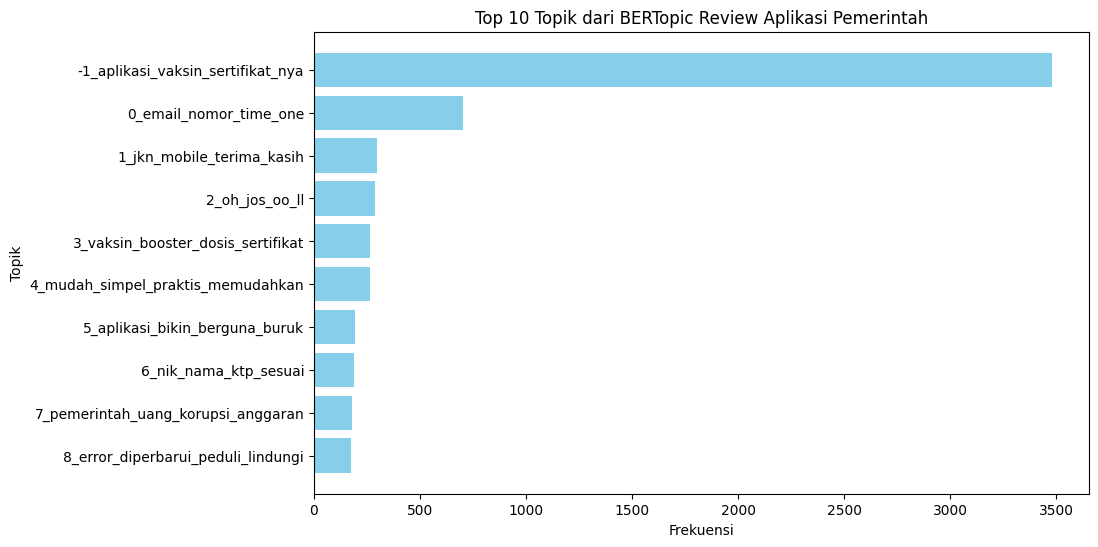

In [ ]:
import matplotlib.pyplot as plt
top_n = 10
top_topics = topic_top_freq.head(top_n)

plt.figure(figsize=(10, 6))
plt.barh(top_topics['Name'], top_topics['Count'], color='skyblue')
plt.xlabel('Frekuensi')
plt.ylabel('Topik')
plt.title(f'Top {top_n} Topik dari BERTopic Review Aplikasi Pemerintah')
plt.gca().invert_yaxis()
plt.show()

## Predict

In [ ]:
# saving model to desired path
# topic_model.save("/kaggle/working/model_bertopic_llama2-3000")

In [ ]:
import joblib

# Simpan model menggunakan joblib
joblib.dump(topic_model, "/kaggle/working/model_bertopic_llama2-3000.joblib")

In [ ]:
# load model
from bertopic import BERTopic

loaded_topic_model = BERTopic.load("/content/drive/MyDrive/Gemastik/Topic Modeling/model_bertopic")

In [ ]:
loaded_topic_model.get_topic_info()

In [ ]:
# predict another sentences
new_sentences = [
    "Produk ini sangat bagus dan kualitasnya luar biasa.",
    "Layanan pelanggan sangat buruk dan saya tidak puas.",
    "Pengiriman cepat dan tepat waktu, sangat memuaskan.",
]

new_topics, new_probs = loaded_topic_model.transform(new_sentences)

# Menampilkan hasil prediksi
for sentence, topic, prob in zip(new_sentences, new_topics, new_probs):
    print(f"Kalimat: {sentence}")
    print(f"Topik yang diprediksi: {topic}")
    print(f"Probabilitas: {prob}\n")